__1.Data Loading__

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [4]:
df = pd.read_csv('IMDB Dataset.csv')

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


__2. Data Preprocessing__

In [7]:
# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [8]:
# Function to clean and preprocess the text
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization and removing stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [9]:
# Apply preprocessing to the dataset
df['cleaned_review'] = df['review'].apply(preprocess_text)

__3. Exploratory Data Analysis (EDA)__

C:\Users\KRITIKA SINGH\AppData\Local\Temp\ipykernel_4084\99113193.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette=palette_colors)


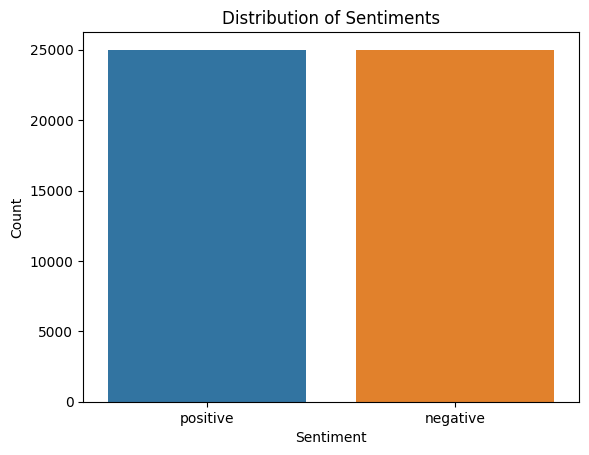

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette
palette_colors = ['#1f77b4', '#ff7f0e']  # Replace with your preferred colors

# EDA - Sentiment Distribution Visualization
sns.countplot(x='sentiment', data=df, palette=palette_colors)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [12]:
# Word Cloud for positive and negative reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['cleaned_review'])
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['cleaned_review'])

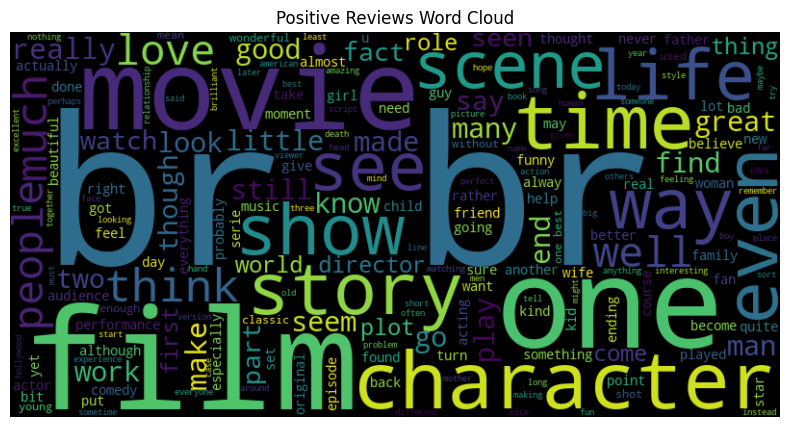

In [13]:
# Positive Word Cloud
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

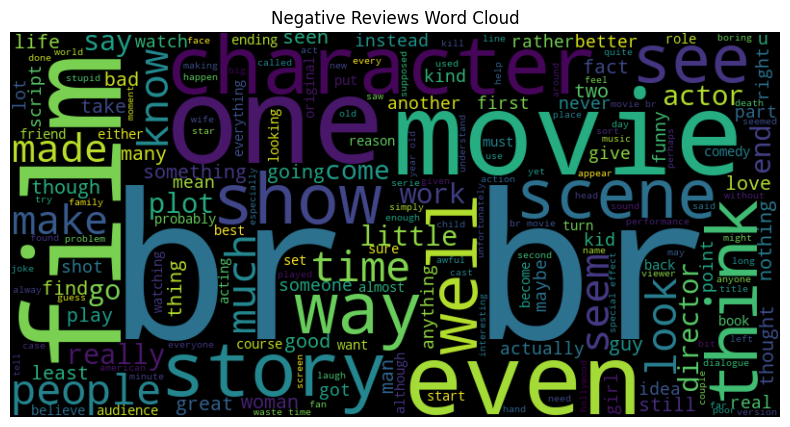

In [14]:
# Negative Word Cloud
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

__4. Feature Engineering__

In [16]:
# Featur Engineering
# Feature 1: Review Length
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

# Feature 2: Sentiment (binary numeric encoding)
df['sentiment_numeric'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Feature 3: Simulate 'purchase behavior' score (based on review length and sentiment)
df['purchase_behavior_score'] = df['review_length'] * df['sentiment_numeric']

__5. K-Means Clustering__

In [17]:
# Scaling Features for K-Means Clustering
features = ['review_length', 'sentiment_numeric', 'purchase_behavior_score']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

In [18]:
# Applying K-Means Clustering
# Elbow Method to find optimal k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

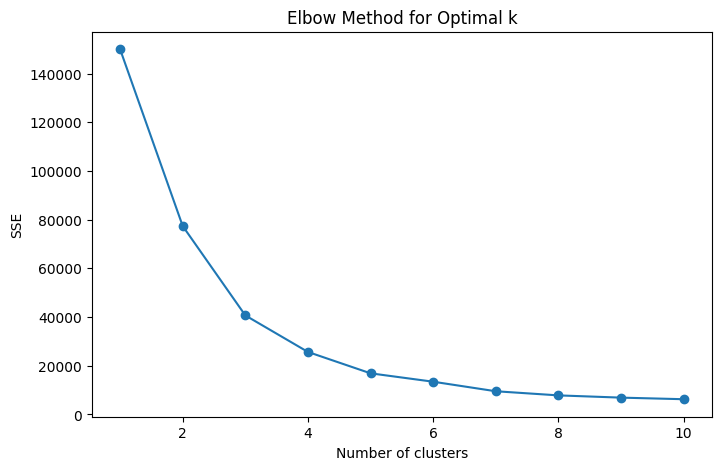

In [19]:
# Plotting the Elbow graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [21]:
# Assuming k=3 based on elbow method
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

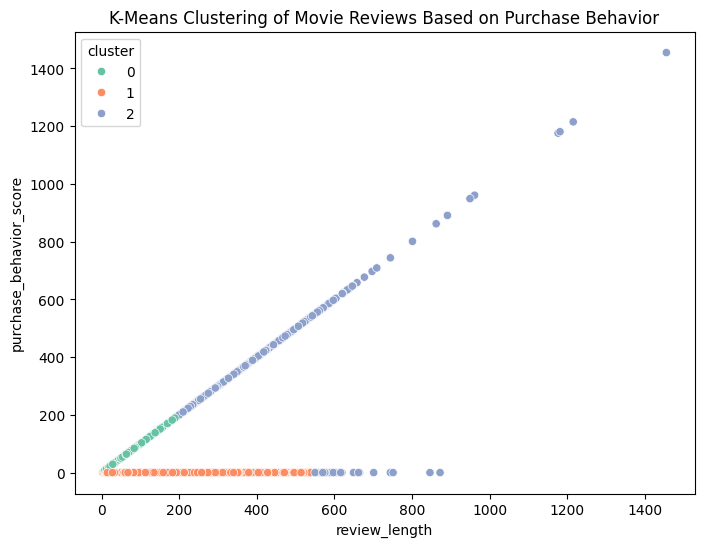

In [22]:
# Visualizing clusters based on review length and purchase behavior score
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['review_length'], y=df['purchase_behavior_score'], hue=df['cluster'], palette='Set2')
plt.title('K-Means Clustering of Movie Reviews Based on Purchase Behavior')
plt.show()

__6. Sentiment Prediction Model__

In [23]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()

# Target variable for sentiment prediction
y = df['sentiment_numeric']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

__7. Model Evaluation__

In [24]:
# Model Evaluation
y_pred = model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.89


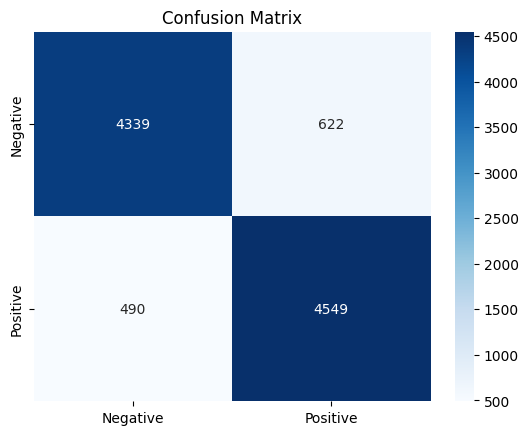

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



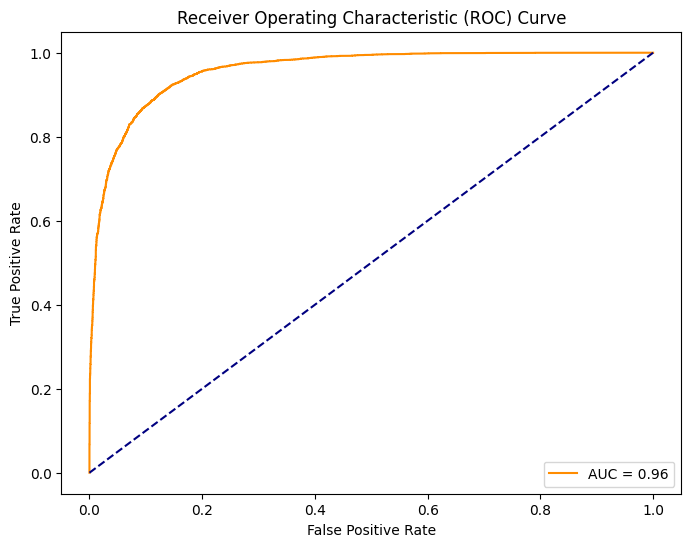

In [28]:
# Visualization - ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

__8. Model Deployment__

In [29]:
# Save the model and vectorizer for deployment
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))